# EDA of Chatbot Arena Dataset 

The purpose of this notebook aims to explore the Chatbot Arena dataset, where two chatbots answer human questions, and users vote on the best response. The EDA of Chatbot Arena Dataset will cover:
- Understanding the dataset structure and contents.
- Exploring the distribution of questions, responses, and chatbots.
- Identifying patterns in the data to guide future modeling tasks.

## Loading the Data

- Conversation Data
- Prompts and Models Response Embeddings
- Topic Modeling and Hardness Score Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_theme(style="whitegrid")

In [2]:
#---- Main Dataset ----#

# Conversation Data
conversation = pd.read_json(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)


#---- Auxiliary Datasets ----#

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

## Data Exploration

### Conversations Dataset EDA

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`).

In [7]:
display(conversation.head())


,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [9]:
display(conversation.info())
display(conversation.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     25282 non-null  object
 1   model_a         25282 non-null  object
 2   model_b         25282 non-null  object
 3   winner          25282 non-null  object
 4   judge           25282 non-null  object
 5   conversation_a  25282 non-null  object
 6   conversation_b  25282 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


None

(25282, 7)

#### Granularity and Cleaning
**Granularity**: the data is on the question-level. The dataset contains conversations from users with different chatbot models. In a row we can see one prompt from a user and the response from two chatbots models for that prompt. The specific models can be different for each conversation. All the columns contain qualitative nominal variables.

In [10]:
# Check for null values in data
conversation.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

**Null Values:** there are no null values in the data.

Next, lets create a winner_model column for easy analysis. For this, we will map 'tie' and 'tie (bothbad)' to just 'tie' string.

In [14]:
conversation['winner_model'] = conversation.apply(lambda row: row['model_a'] if row['winner'] == 'model_a' else (row['model_b'] if row['winner'] == 'model_b' else 'tie'), axis=1)

Let's check the structure of the conversation column.

In [16]:
conversation["conversation_a"].iloc[0]

[{'content': 'What is the difference between OpenCL and CUDA?',
  'role': 'user'},
 {'content': 'OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL is a general-purpose并行编程接口 that allows developers to write parallel code that can run on any platform that supportsCL, which includes most modern operating systems and computer systems, including Windows, Linux, and macOS. It provides a lower-level, more flexible API that is more suitable for building large-scale distributed computing systems.CUDA is a specific implementation ofOpenCL that is designed for performance and scalability in devices with multiple GPU(s). It was developed by Nvidia and is widely used for scientific computing, machine learning, and图形图像处理. The CUDA API provides a high-level, more efficient way to write parallel code that can run on top of a GPU, while still maintaining the ability to write code that can be easily adapted for other parallel computing platforms.',
  'role'

Lets extract out the prompt and chatbot model responses into separate columns. For this we will create separate columns for prompt_a & prompt_b and separate columns for models' reponse_a & response_b. We will also add columns for their length fields and a column for the winner_response.

In [75]:
conversation['conversation_a_user_prompt'] = conversation["conversation_a"].str[0].str["content"]
conversation['conversation_b_user_prompt'] = conversation["conversation_b"].str[0].str["content"]
conversation['user_prompt_length'] = conversation['conversation_a_user_prompt'].apply(len)
conversation['model_a_response'] = conversation['conversation_a'].apply(lambda x: x[1]['content'])
conversation['model_a_response_length'] = conversation['model_a_response'].apply(len)
conversation['model_b_response'] = conversation['conversation_b'].apply(lambda x: x[1]['content'])
conversation['model_b_response_length'] = conversation['model_b_response'].apply(len)
conversation['winner_response'] = conversation.apply(lambda row: row['model_a_response'] if row['winner'] == 'model_a' else (row['model_b_response'] if row['winner'] == 'model_b' else 'tie'), axis=1)
conversation['winner_response_length'] = conversation['winner_response'].apply(len)

Next, check if the user prompt is the same in all rows. If it is different in any row, we will need to fix that.

In [76]:
sum(conversation['conversation_a_user_prompt'] != conversation['conversation_b_user_prompt']) == 0

True

As we can see the user prompt is the same. That means we don't need both the columns we can drop one of them

In [77]:
conversation = conversation.drop(columns=['conversation_b_user_prompt'])
conversation = conversation.rename(columns={"conversation_a_user_prompt": "user_prompt"})

#### Cleaned Dataset
Lets look at the claned dataset

In [78]:
conversation.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,winner_model,user_prompt,user_prompt_length,model_a_response,model_a_response_length,model_b_response,model_b_response_length,user_prompt,winner_response,user_prompt,winner_response_length
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,koala-13b,What is the difference between OpenCL and CUDA?,47,OpenCL and CUDA are two different programming ...,892,OpenCL and CUDA are both programming languages...,1905,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are both programming languages...,What is the difference between OpenCL and CUDA?,1905
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,tie,Why did my parent not invite me to their wedding?,49,It is possible that your parent did not invite...,660,It is likely that they wanted to keep the gues...,514,Why did my parent not invite me to their wedding?,tie,Why did my parent not invite me to their wedding?,3
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...",oasst-pythia-12b,"Fuji vs. Nikon, which is better?",32,Both Fuji and Nikon are popular camera brands ...,1114,This is a subjective question and the answer d...,1566,"Fuji vs. Nikon, which is better?",This is a subjective question and the answer d...,"Fuji vs. Nikon, which is better?",1566
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,oasst-pythia-12b,How to build an arena for chatbots?,35,Building an arena for chatbots can be done by ...,1575,Building an arena for chatbots is a great way ...,1624,How to build an arena for chatbots?,Building an arena for chatbots is a great way ...,How to build an arena for chatbots?,1624
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",vicuna-13b,When is it today?,17,"I'm sorry, I cannot determine the current date...",267,"Today is February 23, 2023.",27,When is it today?,"I'm sorry, I cannot determine the current date...",When is it today?,267


#### Analysis

Now view the statistics of the prompt lengths

In [79]:
# View statistics for the prompt length
conversation['user_prompt_length'].describe()

count    25282.00000
mean       196.74646
std        369.05595
min         16.00000
25%         42.00000
50%         72.00000
75%        156.00000
max       2560.00000
Name: user_prompt_length, dtype: float64

Since the median is less than the mean prompt length, this distribution is right skewed. Let's visualize this.

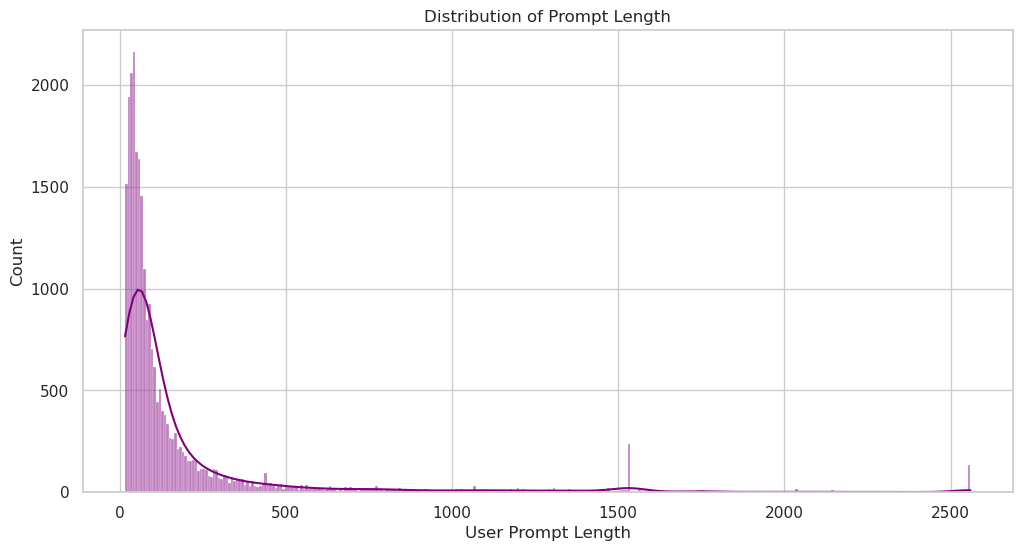

In [98]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(12, 6))
sns.histplot(conversation["user_prompt_length"], kde=True, color='purple')
plt.title("Distribution of Prompt Length")
plt.xlabel('User Prompt Length')
plt.show();

Let's apply this same process to the reponse length for models a and b.

In [99]:
# View statistics for the models' responses

display(conversation['model_a_response_length'].describe())

display(conversation['model_b_response_length'].describe())

count    25282.000000
mean       772.708409
std        655.798032
min          1.000000
25%        232.000000
50%        591.000000
75%       1215.750000
max       9857.000000
Name: model_a_response_length, dtype: float64

count    25282.000000
mean       773.163911
std        658.803491
min          1.000000
25%        232.000000
50%        582.000000
75%       1214.750000
max       7135.000000
Name: model_b_response_length, dtype: float64

Let's visualize the distribution

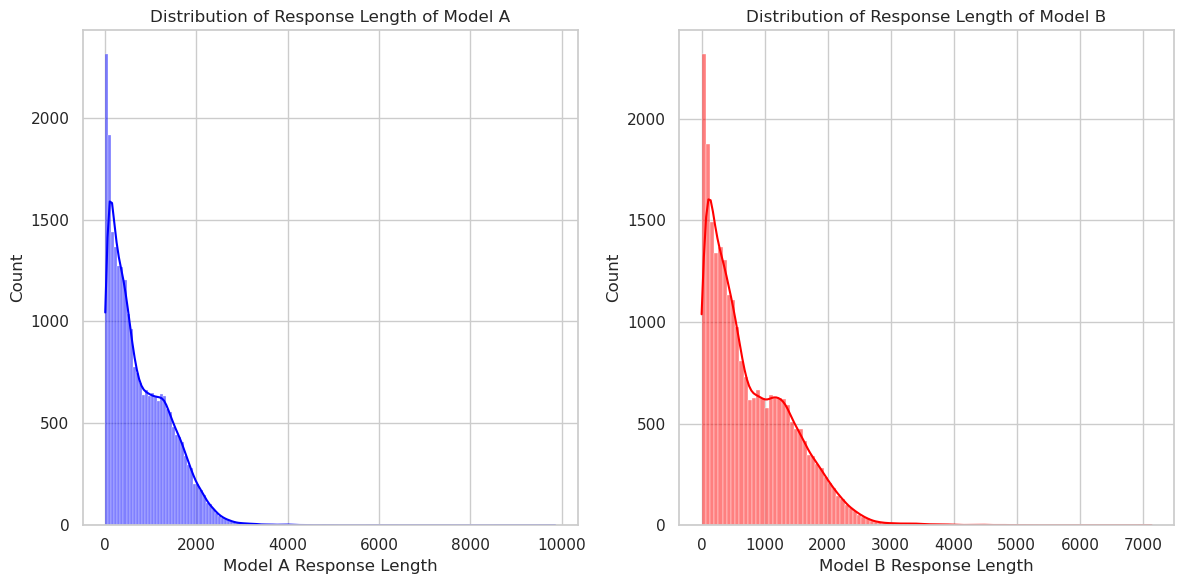

In [100]:
# Set up the subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of the length of the response of model a.
sns.histplot(conversation["model_a_response_length"], ax=ax1, color='blue', kde=True)
ax1.set_title('Distribution of Response Length of Model A')
ax1.set_xlabel('Model A Response Length')

# Plot the distribution of the length of the response of model b.
sns.histplot(conversation["model_b_response_length"], ax=ax2, color='red', kde=True)
ax2.set_title('Distribution of Response Length of Model B')
ax2.set_xlabel('Model B Response Length')

# Adjust layout
plt.tight_layout()
plt.show()

**Takeaways**

- The distribution of user_prompt_length is heavily right-skewed, with the vast majority of prompts being very short. Most prompts fall below 500 characters, and only a few exceed 1000 characters, indicating that users tend to ask concise questions or make brief statements. The density around low values suggests most users short queries, likely without extensive context.
- Both model_a_response_length and model_b_response_length distributions are similarly right-skewed but extend further than the prompt length, reflecting that models tend to generate responses longer than the prompts. Most responses are below 1000 characters, but both models occasionally produce responses up to 4000 characters or more. This indicates that the models adapt to provide detailed responses when needed, though such cases are relatively rare.
- The shapes of the distributions for model_a_response_length and model_b_response_length are quite similar, with comparable peaks and tails, suggesting that both models generate responses of similar length distributions. The high count around the shorter lengths (<500 characters) in both models indicates a tendency to provide concise answers for most prompts, aligning with the user’s tendency to submit shorter queries.
- Both response distributions have some long-tail behavior, with a few responses exceeding 4000 characters. This likely represents instances where models generated detailed responses, possibly for complex or multi-part questions. The outliers indicate the models’ flexibility in producing longer responses when the prompt demands it, though these instances are rare.

Next, lets examine the **distribution of different chatbot models** (both model A and B) used in the conversations. 

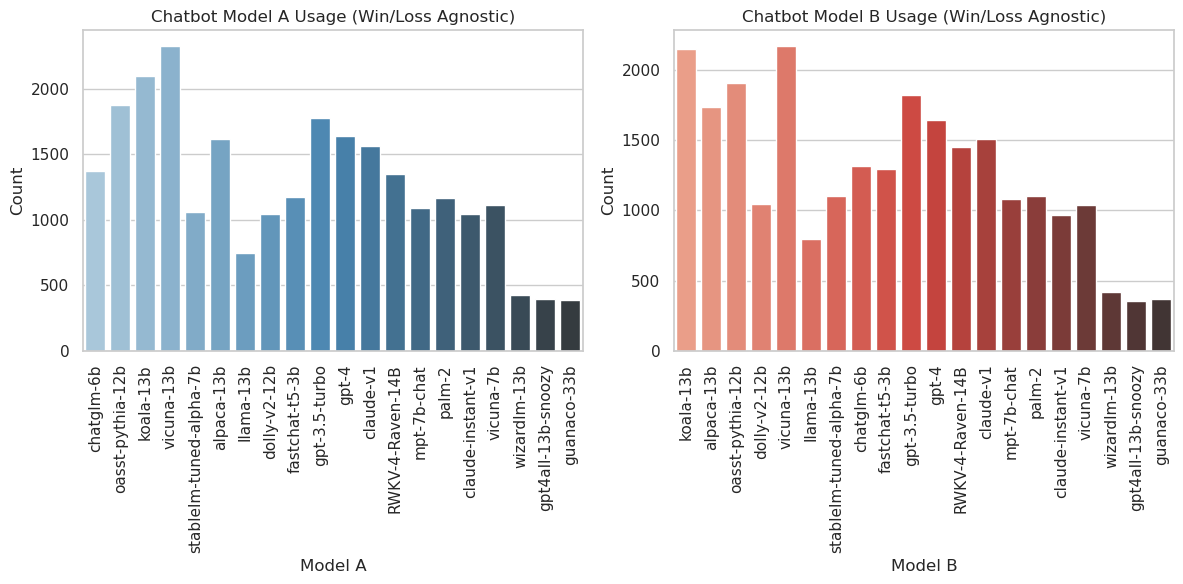

In [101]:
# Set up the subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First bar chart
sns.countplot(data=conversation, x='model_a', ax=ax1, palette='Blues_d')
ax1.set_title('Chatbot Model A Usage (Win/Loss Agnostic)')
ax1.set_xlabel('Model A')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=90)

# Second bar chart
sns.countplot(data=conversation, x='model_b', ax=ax2, palette='Reds_d')
ax2.set_title('Chatbot Model B Usage (Win/Loss Agnostic)')
ax2.set_xlabel('Model B')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

Now lets check the **distribution of the winner models** specifically.

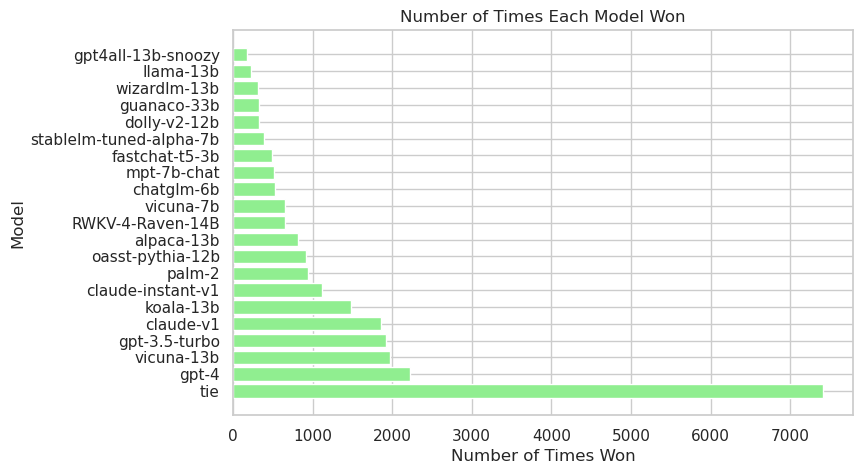

In [102]:
winners = conversation['winner_model'].value_counts()

plt.figure(figsize=(8, 5))
plt.barh(winners.index, winners.values, color='lightgreen')
plt.title('Number of Times Each Model Won')
plt.xlabel("Number of Times Won")
plt.ylabel("Model")
plt.show();

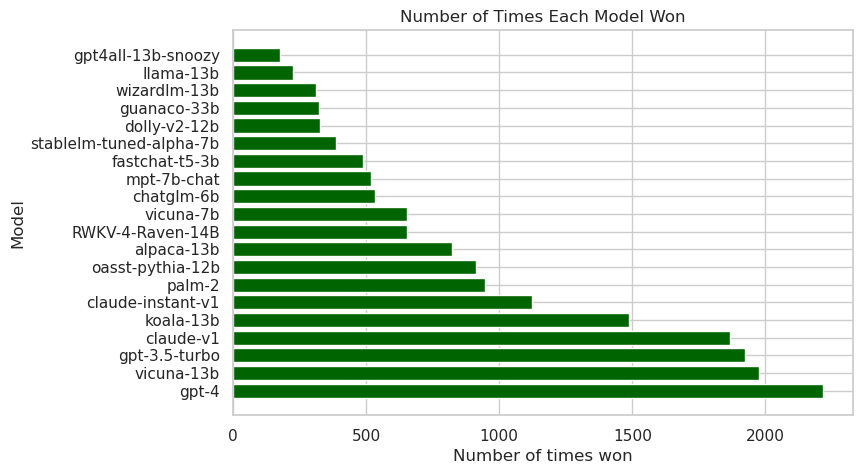

In [103]:
winners_without_tie_df = conversation[conversation['winner_model'] != 'tie']
winners_without_tie = winners_without_tie_df['winner_model'].value_counts()

plt.figure(figsize=(8, 5))
plt.barh(winners_without_tie.index, winners_without_tie.values, color='darkgreen')
plt.title('Number of Times Each Model Won')
plt.xlabel("Number of times won")
plt.ylabel("Model")
plt.show();

Get the win counts of the top-5 winning models.

In [104]:
# Determine the top five highest performing models based on win counts
top_models = winners_without_tie_df.groupby(["winner_model"]).size().reset_index(name = "win_count")
top_models = top_models.sort_values(by = "win_count", ascending = False).head()
top_models

,winner_model,win_count
8,gpt-4,2218
17,vicuna-13b,1974
7,gpt-3.5-turbo,1922
4,claude-v1,1865
11,koala-13b,1487


**Takeaways**
- GPT-4 has the highest win count overall, showing clear dominance. Vicuna-13b and GPT-3.5-turbo are also strong performers, ranking close behind GPT-4 in win counts. When ties are removed, these top models maintain their strong positions, indicating consistent performance in head-to-head comparisons.
- Ties occur frequently, with a significant portion of outcomes marked as ties, indicating that users often find models to be similarly effective.
- The top models by win count without ties are GPT-4, Vicuna-13b, GPT-3.5-turbo, Claude-v1, and Koala-13b. These models outperform the others consistently, suggesting that they provide more satisfying or accurate responses across diverse prompts.
- Models like GPT4All-13b-snoozy, Llama-13b, and Wizardlm-13b have very low win counts, suggesting they are less competitive in this environment.

Next, let's look at the **judge** column that contains the anonymized usernames who held the converstaion and picked the winner model.

In [105]:
len(conversation['judge'].unique())

10531

The dataset contains 10531. Let's check the distribution of number of conversations per user.

In [106]:
judge_value_counts = conversation['judge'].value_counts()
display(judge_value_counts)

display('Total users with more than 50 conversations: ' + str(len(judge_value_counts[judge_value_counts > 50])))

judge
arena_user_9965     307
arena_user_257      288
arena_user_13046    192
arena_user_3820     181
arena_user_15085    178
                   ... 
arena_user_11664      1
arena_user_11581      1
arena_user_11465      1
arena_user_8577       1
arena_user_21247      1
Name: count, Length: 10531, dtype: int64

'Total users with more than 50 conversations: 34'

Out of 10531 users, only 34 users have had more than 50 conversations. So we will get the top 20 users according to the number of conversations held and check the winner models that they frequently picked.

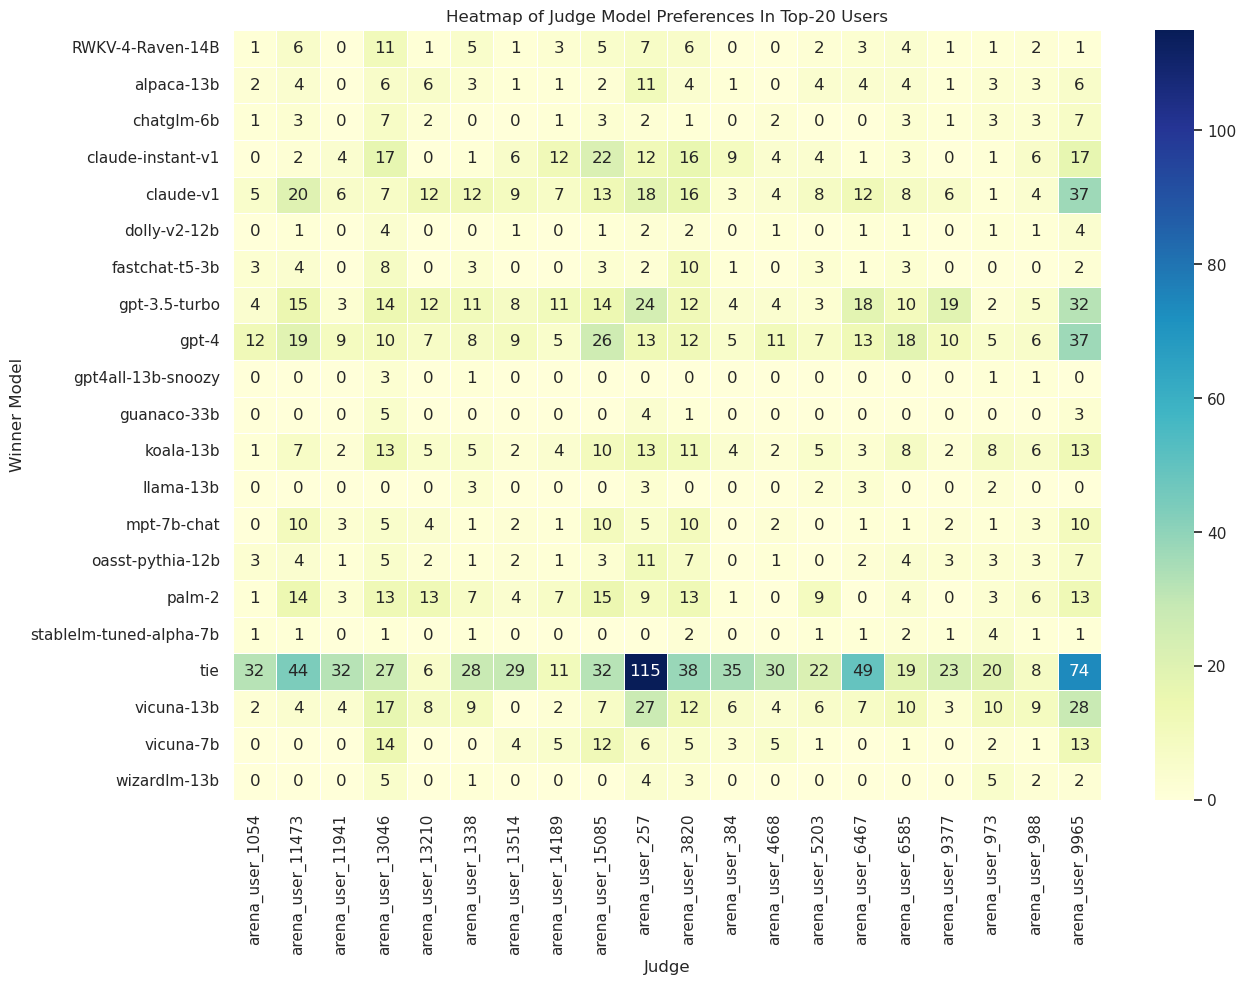

In [107]:
top20_users = conversation['judge'].value_counts()[:20].index
models_picked_by_top20_users = conversation[conversation['judge'].isin(top20_users)]
models_picked_by_top20_users_pivot = models_picked_by_top20_users.pivot_table(index='winner_model', columns='judge', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(models_picked_by_top20_users_pivot, annot=True, cmap="YlGnBu", fmt="d", linewidths=.5)
plt.title("Heatmap of Judge Model Preferences In Top-20 Users")
plt.xlabel("Judge")
plt.ylabel("Winner Model")
plt.show()

**Takeaways**
- Ties are common, with high counts in each judge’s choices (e.g., 115 ties by arena_user_13210), indicating frequent parity between models in responses.
- GPT-4, GPT-3.5-turbo, and Claude-v1 are among the most frequently chosen models, with high counts across several judges (e.g., GPT-4 has 22 wins with arena_user_11473). These models stand out as popular choices across different judges, reinforcing their strong performance.
- Some judges show distinct preferences. For example, arena_user_13210 selects Claude-v1 frequently (22 times), suggesting a possible personal bias or specific evaluation criteria. arena_user_15085 prefers GPT-4 and GPT-3.5-turbo more than other models, indicating consistency in these models' appeal.
- Models like GPT4All-13b-snoozy and Guanaco-33b are rarely chosen as winners, further highlighting their lower competitiveness.

Next, let's check model-pairing performace i.e. within the same pair of models, did some models consistently perform better.

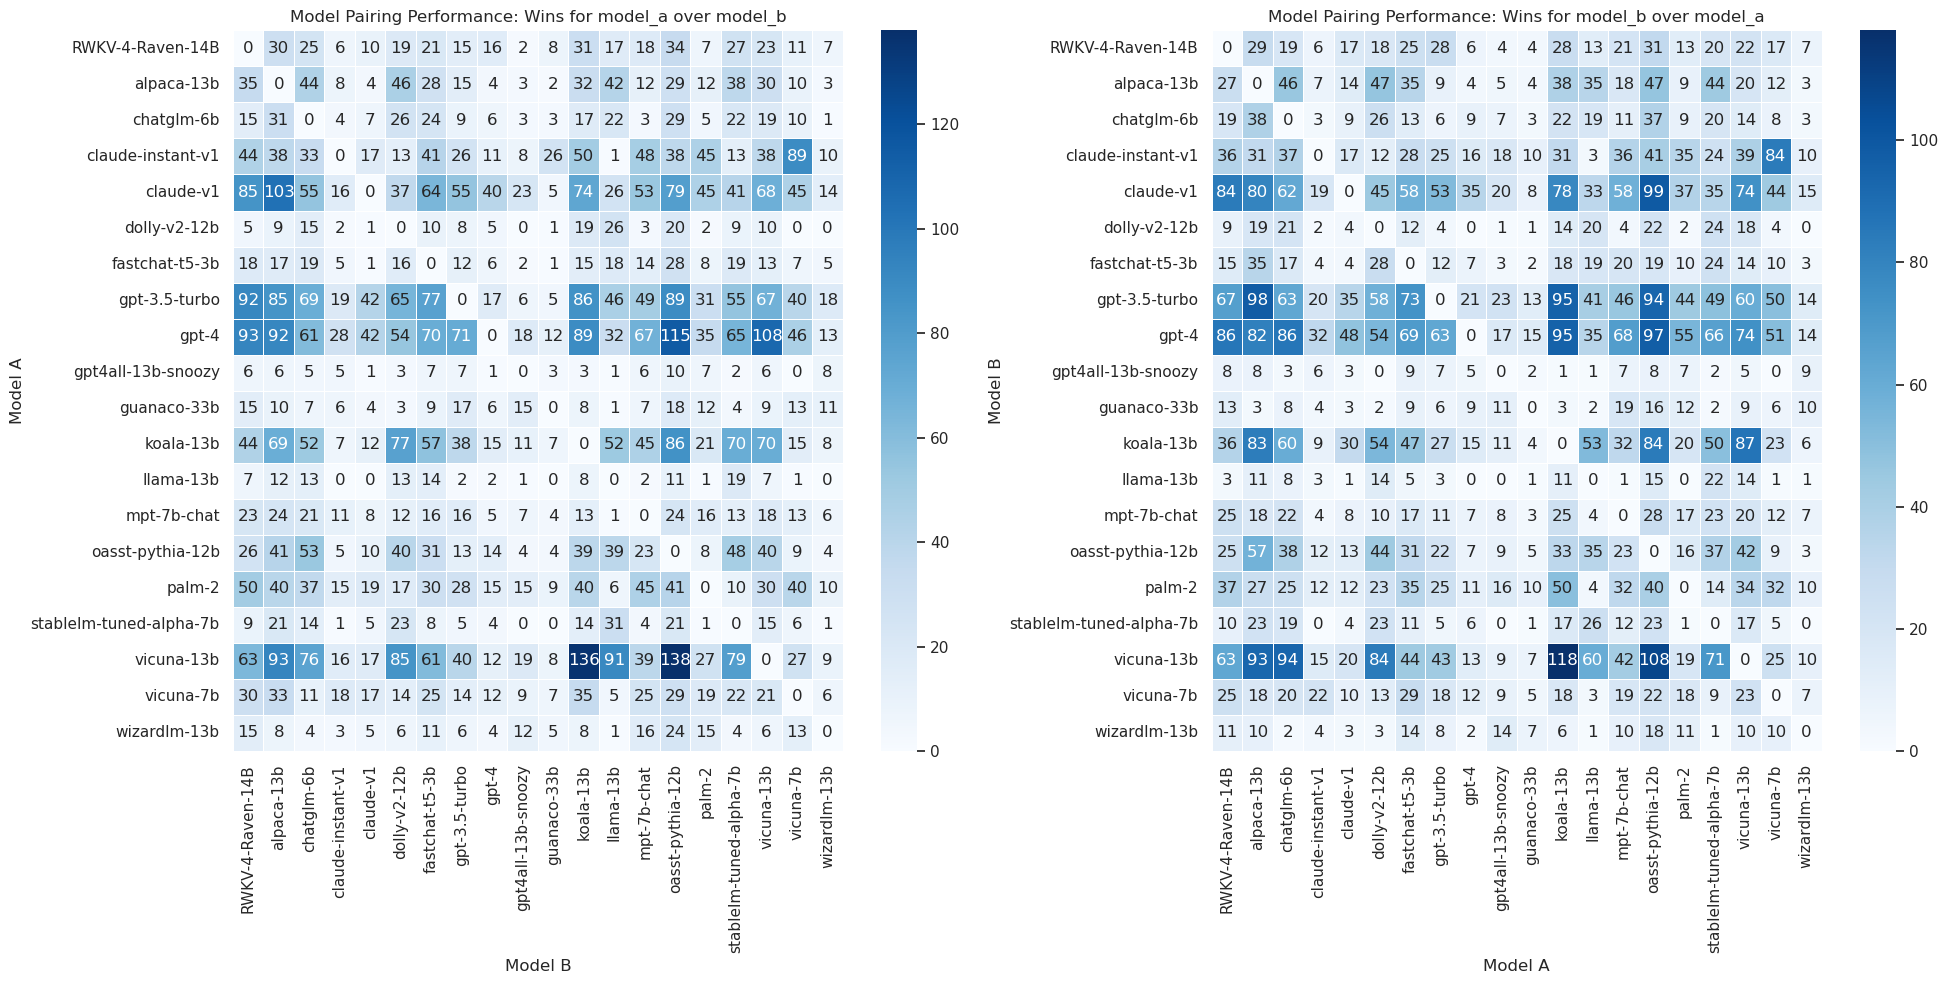

In [108]:
# Filter where model_a is the winner and create a count table
df_model_a_wins = winners_without_tie_df[winners_without_tie_df['winner_model'] == winners_without_tie_df['model_a']]
pairing_performance_a_over_b = df_model_a_wins.pivot_table(
    index='model_a', 
    columns='model_b', 
    aggfunc='size', 
    fill_value=0
)

# Filter where model_b is the winner and create a count table
df_model_b_wins = winners_without_tie_df[winners_without_tie_df['winner_model'] == winners_without_tie_df['model_b']]
pairing_performance_b_over_a = df_model_b_wins.pivot_table(
    index='model_b', 
    columns='model_a', 
    aggfunc='size', 
    fill_value=0
)

# Plot both heatmaps side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for model_a wins over model_b
sns.heatmap(pairing_performance_a_over_b, annot=True, cmap="Blues", fmt="d", linewidths=.5, ax=ax1)
ax1.set_title("Model Pairing Performance: Wins for model_a over model_b")
ax1.set_xlabel("Model B")
ax1.set_ylabel("Model A")

# Heatmap for model_b wins over model_a
sns.heatmap(pairing_performance_b_over_a, annot=True, cmap="Blues", fmt="d", linewidths=.5, ax=ax2)
ax2.set_title("Model Pairing Performance: Wins for model_b over model_a")
ax2.set_xlabel("Model A")
ax2.set_ylabel("Model B")

plt.tight_layout()
plt.show()

**Takeaways**

We have the following takeaways from the two heatmaps above:

1. Consistently Strong Models 
- GPT-4: This model stands out with high win counts against a wide range of opponents. For example:
    - GPT-4 vs GPT-3.5-turbo: GPT-4 won 115 times when it was model_a and 95 times as model_b. This suggests a strong advantage over GPT-3.5-turbo in head-to-head comparisons.
    - GPT-4 vs Claude-v1: Similarly, GPT-4 won 89 times as model_a and 78 times as model_b, indicating it consistently outperformed Claude-v1 regardless of its role.
- Vicuna-13b: Another high-performing model, Vicuna-13b shows significant wins against many models.
    - Vicuna-13b vs GPT-3.5-turbo: Vicuna-13b won 85 times as model_a and 73 times as model_b, illustrating its reliability in this matchup.
    - Vicuna-13b vs Claude-v1: This model also performed well against Claude-v1, winning 61 times as model_a and 58 times as model_b.

3. Consistently Weaker Models: GPT4All-13b-Snoozy and Guanaco-33b have some of the lowest win counts across both heatmaps, indicating that they are generally less competitive.
- GPT4All-13b-Snoozy: Wins only occasionally, such as 6 times against Claude-v1 when it was model_b, and 5 times against GPT-3.5-turbo as model_a. Overall, it struggles against most models.
- Guanaco-33b Shows similar weaknesses, with wins as low as 3 against GPT-4 as model_b, and only 5 times against Claude-instant-v1 as model_a. This low win count across pairings suggests it may lack robustness or versatility.

4. Models From The Same Series
- PT-3.5-turbo vs GPT-4: This pairing is particularly interesting, as GPT-4 shows a clear advantage, but GPT-3.5-turbo still manages some wins. As model_b GPT-3.5-turbo won 63 times against GPT-4, indicating it can occasionally outperform GPT-4 depending on the context or prompt. This matchup suggests that while GPT-4 is generally stronger, GPT-3.5-turbo may have certain contexts or types of conversations where it competes well.
- Claude-v1 vs Claude-instant-v1: Both models from the Claude family, but Claude-v1 shows consistently higher win counts. Claude-v1 won 55 times as model_a against Claude-instant-v1 and 45 times as model_b. This suggests that Claude-v1 might be a more robust model than Claude-instant-v1, even though they belong to the same family.

5. Asymmetrical Pairing Performance: the asymmetrical results suggest that some models might perform differently depending on their position (model_a vs. model_b). This could be due to variations in prompt handling, response strategies, or even random fluctuations in performance. we will explore this further later in our EDA.
- laude-v1 vs Vicuna-13b: In this pairing, Claude-v1 performs relatively well when it’s model_b, winning 58 times, compared to 61 wins for Vicuna-13b. However, when Claude-v1 is model_a, Vicuna-13b wins significantly more frequently, with 85 wins compared to 40 for Claude-v1.
- GPT-3.5-turbo vs Claude-instant-v1: When GPT-3.5-turbo is model_a, it wins 42 times compared to 18 wins for Claude-instant-v1. But when Claude-instant-v1 is model_a, it wins more often, with 33 wins versus 30 for GPT-3.5-turbo.

Next, let's analyze the response of the top-5 winnings models and of the best model.

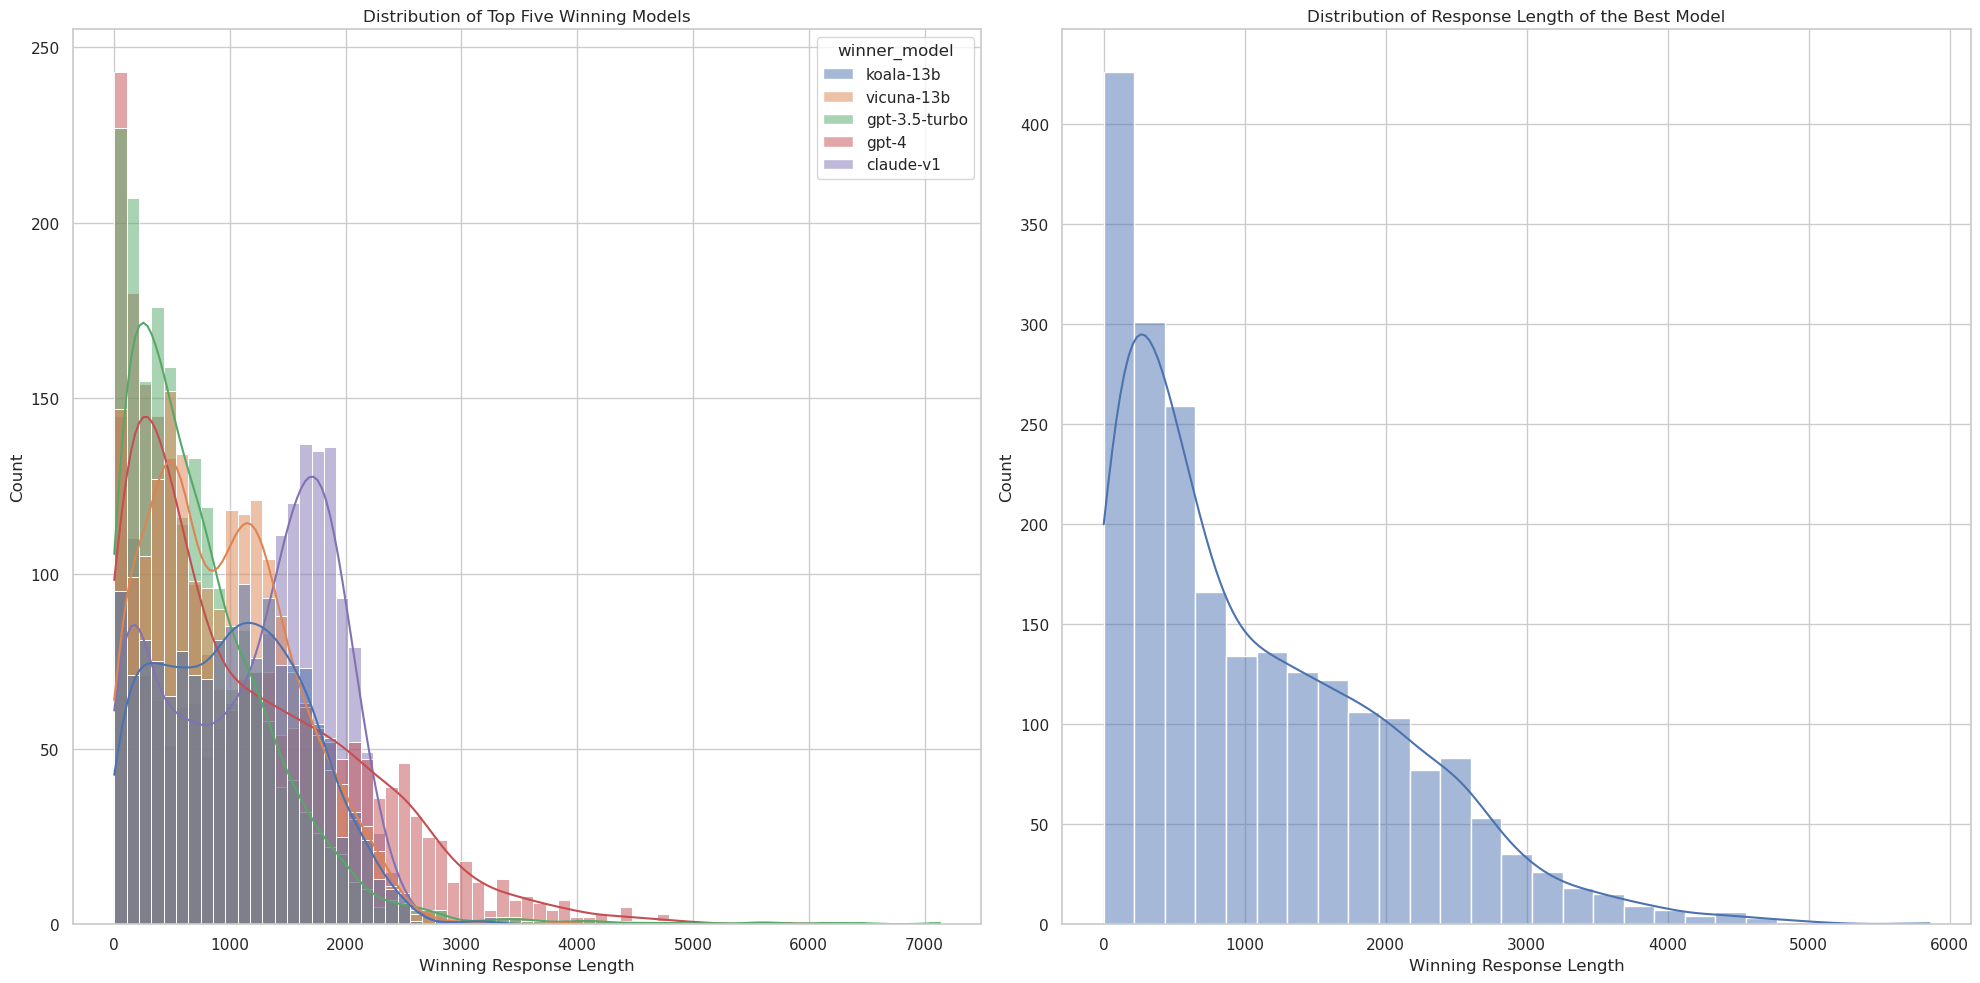

In [97]:
# Filter the top models to only include the top five models
top_five = list(top_models["winner_model"])
df_top_five = winners_without_tie_df[winners_without_tie_df["winner_model"].isin(top_five)]
best_model = winners_without_tie_df[winners_without_tie_df["winner_model"] == 'gpt-4']

# Set up the subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First histogram
sns.histplot(data = df_top_five, x = "winner_response_length", hue = "winner_model", kde = True, ax=ax1)
ax1.set_title("Distribution of Top Five Winning Models")
ax1.set_xlabel("Winning Response Length")

# Second histogram
sns.histplot(best_model["winner_response_length"], kde=True, ax=ax2)
ax2.set_title("Distribution of Response Length of the Best Model")
ax2.set_xlabel("Winning Response Length")

# Adjust layout
plt.tight_layout()
plt.show()

**Takeaways**
- All top 5 winning models have right-skewed distributions, with most responses clustering below 1000 characters. This indicates a user preference for concise answers across models. However, to confirm that we still need to check the distribution of the loser model responses to see if there is a difference.

Let's also check the summary statistics of winner and loser models side-by-side w.r.t the response lengths.

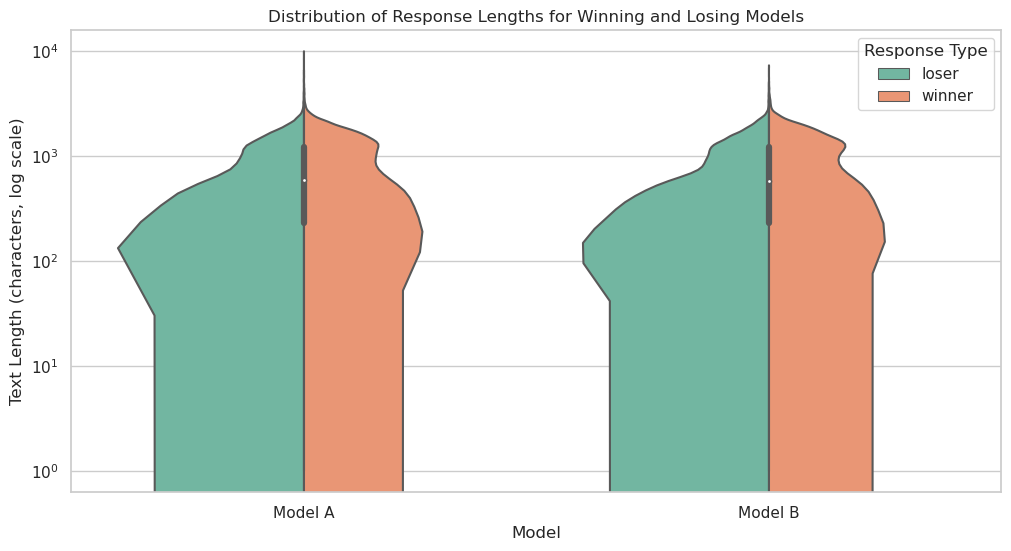

In [112]:
violit_plot_conversation_copy = conversation.copy()

# Create a column indicating whether each response is from the winning or losing model
violit_plot_conversation_copy['model_a_win'] = violit_plot_conversation_copy['winner_model'] == violit_plot_conversation_copy['model_a']
violit_plot_conversation_copy['model_b_win'] = violit_plot_conversation_copy['winner_model'] == violit_plot_conversation_copy['model_b']

# Add columns indicating if the response is from the winner or loser
violit_plot_conversation_copy['model_a_response_type'] = violit_plot_conversation_copy['model_a_win'].apply(lambda x: 'winner' if x else 'loser')
violit_plot_conversation_copy['model_b_response_type'] = violit_plot_conversation_copy['model_b_win'].apply(lambda x: 'winner' if x else 'loser')

# Reshape the DataFrame for plotting
lengths_df = pd.DataFrame({
    'Length': violit_plot_conversation_copy['model_a_response_length'].tolist() + violit_plot_conversation_copy['model_b_response_length'].tolist(),
    'Type': violit_plot_conversation_copy['model_a_response_type'].tolist() + violit_plot_conversation_copy['model_b_response_type'].tolist(),
    'Model': ['Model A'] * len(violit_plot_conversation_copy) + ['Model B'] * len(violit_plot_conversation_copy)
})

# Plotting the violin plot with response lengths separated by winner/loser status
plt.figure(figsize=(12, 6))
sns.violinplot(x='Model', y='Length', hue='Type', data=lengths_df, palette='Set2', split=True)
plt.yscale('log')  # Log scale to accommodate length variability
plt.title("Distribution of Response Lengths for Winning and Losing Models")
plt.xlabel("Model")
plt.ylabel("Text Length (characters, log scale)")
plt.legend(title="Response Type")
plt.show()

**Takeaways**
- This negates our earlier belief that only winner models have shorter response length. We can see that Both Model A and Model B show overlapping distributions for winners and losers, indicating that response length alone does not determine winning or losing. The models produce similar-length responses regardless of outcome.
- However, we do see that winners have a slightly wider spread in length, especially in the higher range (10^3 characters or more). This suggests that winning responses may sometimes be more elaborate or detailed but not consistently so.
- The similarity in distribution shape for both Model A and Model B implies that both models respond with comparable verbosity, regardless of whether they win or lose.

### Key Observations and Takeaways From Conversation Dataset

- **Do arena users ask long or short questions? What is the average length of prompts users give to the chatbots?**
Most users ask pretty short questions, with prompt lengths heavily skewed toward the shorter end—under 500 characters. Very few prompts go beyond 1000 characters, which suggests that users tend to ask straightforward questions or make simple statements without too much detail.

- **Describe the length of the response for models in general. In general, what is the average response length for a model?**
Both `model_a_response_length` and `model_b_response_length` show similar right-skewed distributions, generally producing responses longer than the prompts. Most responses are under 1000 characters, but some reach up to 4000 characters, indicating that the models are capable of generating more detailed responses when needed.

- **What are the top five models based on winning from either model a or model b?**
The top five winning models are GPT-4, Vicuna-13b, GPT-3.5-turbo, Claude-v1, and Koala-13b. These models consistently outperform others in head-to-head comparisons, showing they’re able to handle diverse prompts well.

- **Describe the distribution of the top five models based solely on wins. What is the average response length of the top five models compared to models in general?**
or the top five models, response lengths show a similar right-skewed pattern, with most responses under 1000 characters. GPT-4, however, stands out a bit with a wider range, showing it can produce more detailed responses when needed, which may contribute to its high win rate.

- **What is the best model based solely on wins? Describe its distribution and compare its statistics versus the general case of the top five models.**
GPT-4 is identified as the best model based on win count. Its response length distribution is similar to the other top models but shows a broader range, especially on the longer side. This flexibility in producing both concise and detailed answers may be a factor in its consistent wins.

- **Does response length alone determine winning or losing?**
Response length by itself doesn’t seem to make or break a win. Both `Model A` and `Model B` show similar response length patterns for winners and losers, suggesting that other factors—like response quality—probably play a bigger role. That said, winning responses sometimes have a slightly wider spread in length, especially at the upper end.

- **How frequently do ties occur, and what might this indicate about model performance?**
Ties are fairly common, with certain judges choosing "tie" often. This points to a lot of instances where models perform similarly, suggesting that both may be providing equally useful or relevant responses.

- **Are there judge-specific preferences or biases?**
Yes, some judges do show clear favorites. For example, `arena_user_13210` often picks Claude-v1, while `arena_user_15085` leans towards GPT-4 and GPT-3.5-turbo. This could hint at personal biases or just consistent preferences for certain response styles.

- **Which models are consistently strong or weak across different pairings?**
GPT-4** and Vicuna-13b are strong performers, winning against many other models across the board. On the flip side, models like GPT4All-13b-snoozy and Guanaco-33b rarely win, which suggests they struggle to keep up with the competition. GPT-4 stands out with strong results against GPT-3.5-turbo and Claude-v1, showing a clear competitive edge.

- **Do models from the same family (e.g., Claude-v1 vs Claude-instant-v1) perform similarly?**
Not always. While Claude-v1 and Claude-instant-v1 come from the same family, Claude-v1 consistently performs better, hinting at differences in capability even among related models.

- **Are there any notable asymmetries in model performance based on their position as `model_a` or `model_b`?**
Yes, in some cases, models perform differently depending on whether they’re in the `model_a` or `model_b` position. For example, Claude-v1 does better as `model_b` against Vicuna-13b, while GPT-3.5-turbo has more wins as `model_a` against Claude-instant-v1. These differences could be due to varying prompt-handling techniques or just random performance fluctuations.